In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
from bassestimate import BassEstimate
from abmdiffuse_sp import Diffuse
from generate_params_boundary_sp import Gen_para
from pymongo import MongoClient
import numpy as np
import pylab as pl
import networkx as nx
import time

In [2]:
client = MongoClient('localhost', 27017)
db = client.abmDiffusion
prj = db.sparcity

## 目标网络

In [3]:
txt_cont = ['gnm_random_graph(10000,1000)', 'gnm_random_graph(10000,2000)',
    'gnm_random_graph(10000,4000)', 'gnm_random_graph(10000,6000)',
    'gnm_random_graph(10000,8000)', 'gnm_random_graph(10000,10000)', 
    'gnm_random_graph(10000,20000)']

g_cont = [eval('nx.' + g) for g in txt_cont]

## 可视化探索

Time elasped:13.74s
网络连边数量:1000
最大采纳量238, 最大时间步:1
Exceed the maximal iteration: 100
Time elapsed: 2.27s
P:0.0331   Q:0.0149   M:7202
r^2:0.9712


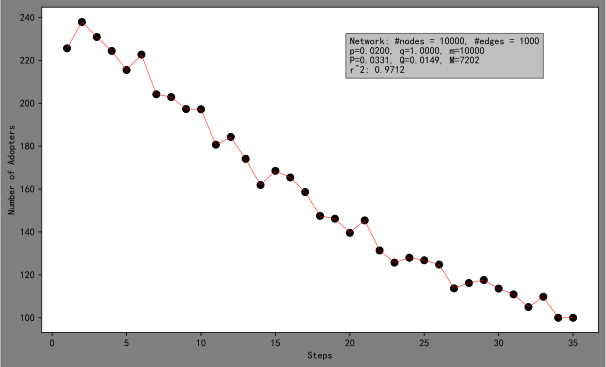

In [28]:
i = 0
g = g_cont[i]
num_edges = g.number_of_edges()

t1 = time.perf_counter()
p, q = 0.02, 1
diff = Diffuse(p, q, g=g)
diff_cont = diff.repete_diffuse()
S = np.mean(diff_cont, axis=0)
print(f"Time elasped:{time.perf_counter()-t1:.2f}s")
print(f"网络连边数量:{num_edges}")
print(f"最大采纳量{np.max(S):.0f}, 最大时间步:{np.argmax(S)}")

m_idx = np.argmax(S)
s = S[:m_idx + 20]
t1 = time.process_time()
para_range = [[1e-5, 0.1], [1e-5, 0.8], [sum(s), 10*sum(s)]]
bassest = BassEstimate(s, para_range)
mse, P, Q, M = bassest.optima_search(c_n=100, threshold=10e-6)
r_2 = bassest.r2([P, Q, M])
print(f'Time elapsed: {(time.process_time() - t1):.2f}s')
print(f'P:{P:.4f}   Q:{Q:.4f}   M:{M:.0f}\nr^2:{r_2:.4f}')

fig = pl.figure(figsize=(10, 6), facecolor='grey')
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("Steps")
ax.set_ylabel("Number of Adopters")
ax.plot(np.arange(1, len(S)+1), S, 'r-', lw=0.5)
ax.scatter(np.arange(1, len(S)+1), S, s=50, marker='o', c='k')
text = ax.text(20, np.max(S) * 0.9, f"Network: #nodes = 10000, #edges = {num_edges}\np={p:.4f}, q={q:.4f}, m={nx.number_of_nodes(diff.g)}\nP={P:.4f}, Q={Q:.4f}, M={M:.0f}\nr^2: {r_2:.4f}", 
                bbox=dict(facecolor='grey', alpha=0.5))

## 生成实验参数边界

In [ ]:
t1 = time.perf_counter()

p_cont = (0.0005, 0.03)
q_cont = (0.08*3, 0.12*3)
delta = (0.001, 0.001)

print(txt_cont[i])
ger_samp = Gen_para(p_cont=p_cont, q_cont=q_cont, g=g, delta=delta)
bound = ger_samp.identify_range()
print(f'time: {time.perf_counter() - t1:.2f}s')
print(bound)

## 写入参数

In [ ]:
prj.insert_one({"_id": txt_cont[i], "param_boundary": bound})

## 批处理

In [ ]:
for j, txt in enumerate(txt_cont):
    t1 = time.perf_counter()
    print(j + 1, )
    g = g_cont[txt]
    p_cont = (0.0005, 0.03)
    q_cont = (0.08*3, 0.12*3)
    delta = (0.001*5, 0.01*5)
    ger_samp = Gen_para(p_cont=p_cont, q_cont=q_cont, g=g)
    bound = ger_samp.identify_range()
    prj.insert_one({"_id": txt_cont[i], "param_boundary": bound})
    print(f'  time: {time.perf_counter() - t1:.2f}s')